In [8]:
import pandas as pd, glob, json, os

rows = []
for cfg in ["SINGLE","MULTI"]:
    for f in glob.glob(f"raw_results/{cfg}/HumanEval_*.json"):
        d = json.load(open(f))
        rows.append({"task": os.path.basename(f)[:-5],
                     "config": cfg,
                     "passed": d["passed"],
                     "tokens": d["tokens"]})

df = pd.DataFrame(rows)
pivot = df.pivot(index="task", columns="config", values="passed")
print("MULTI가 추가로 통과한 문제 수:",
      ((pivot["MULTI"]==True) & (pivot["SINGLE"]==False)).sum())


MULTI가 추가로 통과한 문제 수: 15


In [12]:
import json, glob, pandas as pd, numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# 1) 결과 파일 읽기 ----------------------------------------------------------------
rows = []
for fp in glob.glob("raw_results/*/HumanEval_*.json"):
    d = json.load(open(fp))
    rows.append({
        "task":   d["task_id"].split("/")[-1],    # e.g. "69"
        "config": d["config"],                    # SINGLE | MULTI
        "passed": d["passed"],
        "tokens": d["tokens"],
        "file":   fp                              # 경로 백업
    })
df = pd.DataFrame(rows)

# 2) 피벗 테이블 (통과/토큰) ---------------------------------------------------------
pivot_pass   = df.pivot(index="task", columns="config", values="passed")
pivot_tokens = df.pivot(index="task", columns="config", values="tokens")

# 3) 분류: 두 파이프라인 결과 비교 ---------------------------------------------------
pivot_pass["improved"]  = (pivot_pass["MULTI"] & ~pivot_pass["SINGLE"])
pivot_pass["regressed"] = (~pivot_pass["MULTI"] &  pivot_pass["SINGLE"])
pivot_pass["tie_pass"]  = (pivot_pass["MULTI"] &  pivot_pass["SINGLE"])
pivot_pass["tie_fail"]  = (~pivot_pass["MULTI"] & ~pivot_pass["SINGLE"])

# 4) 요약 통계 ----------------------------------------------------------------------
summary = pd.Series({
    "SINGLE_acc":  pivot_pass["SINGLE"].mean(),
    "MULTI_acc":   pivot_pass["MULTI"].mean(),
    "improved":    pivot_pass["improved"].sum(),
    "regressed":   pivot_pass["regressed"].sum(),
    "both_pass":   pivot_pass["tie_pass"].sum(),
    "both_fail":   pivot_pass["tie_fail"].sum(),
    "tokens_per_pass_S": (
        pivot_tokens["SINGLE"]/pivot_pass["SINGLE"].replace(0, np.nan)
    ).mean(),
    "tokens_per_pass_M": (
        pivot_tokens["MULTI"]/pivot_pass["MULTI"].replace(0, np.nan)
    ).mean()
})

# 5) McNemar 검정 -------------------------------------------------------------------
b = int(pivot_pass["improved"].sum())   # MULTI만 통과
c = int(pivot_pass["regressed"].sum())  # SINGLE만 통과
mcnemar_p = mcnemar([[0, b],[c, 0]], exact=False).pvalue
summary["mcnemar_p"] = mcnemar_p

# 6) CSV·표 출력 --------------------------------------------------------------------
summary.to_csv("analysis/summary.csv")
pivot_pass.to_csv("analysis/task_matrix.csv")

print(summary.round(3))
print("\n**향상된 문제 TOP 10**")
print(pivot_tokens[pivot_pass["improved"]].sort_values("MULTI").head(10))


SINGLE_acc             0.872
MULTI_acc              0.963
improved              15.000
regressed              0.000
both_pass            143.000
both_fail              6.000
tokens_per_pass_S        inf
tokens_per_pass_M        inf
mcnemar_p              0.000
dtype: float64

**향상된 문제 TOP 10**
config  MULTI  SINGLE
task                 
28       2786     330
22       2923     392
12       3163     465
9        3294     475
5        3318     488
4        3397     466
29       3404     400
8        3602     462
111      3706     546
26       3812     431


In [10]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 2.5 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


✅  그래프 저장: figures/improvement_bar.png


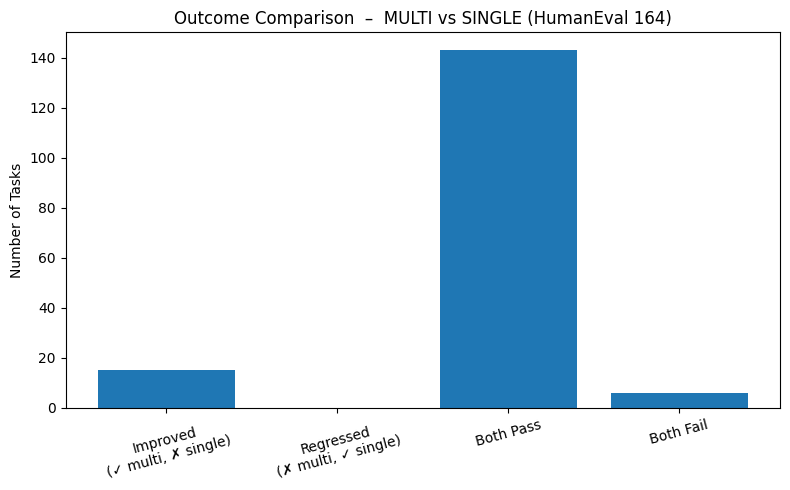

In [13]:
import json, glob, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 1. 결과 읽기 ──────────────────────────────────────────
rows = []
for fp in glob.glob("raw_results/*/HumanEval_*.json"):
    with open(fp) as f:
        d = json.load(f)
    rows.append({
        "task":   d["task_id"].split("/")[-1],   # 0 ~ 163
        "config": d["config"],                  # SINGLE | MULTI
        "passed": d["passed"],
        "tokens": d["tokens"]
    })
df = pd.DataFrame(rows)

# 2. SINGLE ↔ MULTI 매트릭스 만들기
pivot = df.pivot(index="task", columns="config", values="passed")\
          .reindex(columns=["SINGLE", "MULTI"]).fillna(False)

improved   =  pivot["MULTI"] & ~pivot["SINGLE"]   # ✓ multi, ✗ single
regressed  = ~pivot["MULTI"] &  pivot["SINGLE"]   # ✗ multi, ✓ single
both_pass  =  pivot["MULTI"] &  pivot["SINGLE"]
both_fail  = ~pivot["MULTI"] & ~pivot["SINGLE"]

counts = {
    "Improved\n(✓ multi, ✗ single)": int(improved.sum()),
    "Regressed\n(✗ multi, ✓ single)": int(regressed.sum()),
    "Both Pass": int(both_pass.sum()),
    "Both Fail": int(both_fail.sum())
}

# 3. 막대그래프 그리기  (matplotlib, 색 지정 X)
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of Tasks")
plt.title("Outcome Comparison  –  MULTI vs SINGLE (HumanEval 164)")
plt.xticks(rotation=15)
plt.tight_layout()

Path("figures").mkdir(exist_ok=True)
plt.savefig("figures/improvement_bar.png")
print("✅  그래프 저장: figures/improvement_bar.png")


In [14]:
# ── scripts/analyze_improvement.py ───────────────────────────────────────────
import json, glob, re
from pathlib import Path
import pandas as pd

def strip_fence(text: str) -> str:
    m = re.search(r"```(?:python)?\s*(.*?)```", text, flags=re.S)
    return m.group(1).strip() if m else text.strip()

# 1) 결과 파일 스캔 ------------------------------------------------------------
single = {Path(p).stem.split("_")[-1]: p
          for p in glob.glob("raw_results/SINGLE/HumanEval_*.json")}
multi  = {Path(p).stem.split("_")[-1]: p
          for p in glob.glob("raw_results/MULTI/HumanEval_*.json")}

rows = []
for tid, s_path in single.items():
    if tid not in multi:            # 둘 다 있어야 비교 가능
        continue
    with open(s_path) as f: s = json.load(f)
    with open(multi[tid]) as f: m = json.load(f)

    code_s = strip_fence(s["code"])
    code_m = strip_fence(m["code"])

    rows.append({
        "task":         tid,
        "SINGLE_pass":  bool(s.get("passed", False)),
        "MULTI_pass":   bool(m.get("passed", False)),
        "improved":     bool(m.get("passed", False) and not s.get("passed", False)),
        "regressed":    bool(s.get("passed", False) and not m.get("passed", False)),
        "tokens_S":     s.get("tokens", None),
        "tokens_M":     m.get("tokens", None),
        "token_delta":  m.get("tokens", 0) - s.get("tokens", 0),
        "lines_S":      len(code_s.splitlines()),
        "lines_M":      len(code_m.splitlines()),
        "line_delta":   len(code_m.splitlines()) - len(code_s.splitlines())
    })

df = pd.DataFrame(rows)

# 2) 저장 + 인터랙티브 표 -------------------------------------------------------
Path("analysis").mkdir(exist_ok=True)
df.to_csv("analysis/improvement_overview.csv", index=False)

# 앞 20개 개선 사례 표시
imp = df[df["improved"]].sort_values("task").head(20)
imp

,task,SINGLE_pass,MULTI_pass,improved,regressed,tokens_S,tokens_M,token_delta,lines_S,lines_M,line_delta
69,001,False,True,True,False,562,4167,3605,25,32,7
128,004,False,True,True,False,466,3397,2931,12,17,5
156,005,False,True,True,False,488,3318,2830,20,17,-3
135,008,False,True,True,False,462,3602,3140,15,18,3
150,009,False,True,True,False,475,3294,2819,17,12,-5
10,010,False,True,True,False,507,4567,4060,10,30,20
122,012,False,True,True,False,465,3163,2698,16,18,2
63,017,False,True,True,False,575,3816,3241,22,22,0
45,020,False,True,True,False,596,4301,3705,20,26,6
86,022,False,True,True,False,392,2923,2531,4,5,1
